# MLP robustness on MNIST

In this notebook we evaluate the samples we collected over different runs on MNIST.

In [36]:
import os
from jax import numpy as jnp
import numpy as onp
import jax
import tensorflow.compat.v2 as tf
import argparse
import time
import tqdm
from collections import OrderedDict

from bnn_hmc.utils import data_utils
from bnn_hmc.utils import models
from bnn_hmc.utils import metrics
from bnn_hmc.utils import losses
from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import precision_utils

from itertools import chain

from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
dtype = jnp.float32
train_set, test_set, task, data_info = data_utils.make_ds_pmap_fullbatch(
    "mnist", dtype)
test_labels = test_set[1]

net_apply, net_init = models.get_model("mlp_classification", data_info)
net_apply = precision_utils.rewrite_high_precision(net_apply)
(_, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)

In [3]:
def predict_hmc(ds, basepath):
    basepath = os.path.join(basepath, "model_step_{}.pt")
    ensemble_predictions = None
    num_ensembled = 0
    last_test_predictions = None
    for i in tqdm.tqdm(range(11, 100)):
        path = basepath.format(i)
        try:
            checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        except:
            continue
        _, params, net_state, _, _, accepted, _, _ = (
            checkpoint_utils.parse_hmc_checkpoint_dict(checkpoint_dict))
        if accepted:
            _, test_predictions = onp.asarray(
                predict_fn(net_apply, params, net_state, ds))
            ensemble_predictions = ensemble_upd_fn(
                ensemble_predictions, num_ensembled, test_predictions)
            num_ensembled += 1
            last_test_predictions = test_predictions
    print(num_ensembled)
    return ensemble_predictions, last_test_predictions
        

In [18]:
alldirs = {}
prefix = "../runs/hmc/mnist/gaussian"
dirs = os.listdir(prefix)
for path in dirs:
    full_path = os.path.join(prefix, path)
    wd = float(full_path.split("_")[4])
    stepsize = float(full_path.split("_")[6])
    trajlen = float(full_path.split("_")[8])
#     name = "Gaussian wd={} T=1".format(wd, stepsize)
    alldirs[wd] = full_path
        
alldirs

{1.0: '../runs/hmc/mnist/gaussian/model_mlp_classification_wd_1.0_stepsize_0.00010471975511965977_trajlen_1.5707963267948966_burnin_10_mh_True_temp_1.0_seed_11',
 3.0: '../runs/hmc/mnist/gaussian/model_mlp_classification_wd_3.0_stepsize_6.045997880780726e-05_trajlen_0.9068996821171089_burnin_10_mh_True_temp_1.0_seed_11',
 10.0: '../runs/hmc/mnist/gaussian/model_mlp_classification_wd_10.0_stepsize_3.311529421932033e-05_trajlen_0.496729413289805_burnin_10_mh_True_temp_1.0_seed_11',
 30.0: '../runs/hmc/mnist/gaussian/model_mlp_classification_wd_30.0_stepsize_1.9119124031818254e-05_trajlen_0.2867868604772738_burnin_10_mh_True_temp_1.0_seed_11',
 100.0: '../runs/hmc/mnist/gaussian/model_mlp_classification_wd_100.0_stepsize_1.0471975511965977e-05_trajlen_0.15707963267948966_burnin_10_mh_True_temp_1.0_seed_11',
 0.3: '../runs/hmc/mnist/gaussian/model_mlp_classification_wd_0.3_stepsize_0.00019119124031818254_trajlen_2.867868604772738_burnin_10_mh_True_temp_1.0_seed_11',
 0.1: '../runs/hmc/mnis

In [19]:
sgddirs = {}
prefix = "../runs/sgd/mnist/"

dirs = os.listdir(prefix)
for path in dirs:
    if path[:3] != "sgd":
        continue
    full_path = os.path.join(prefix, path, "model_step_99.pt")
    wd = float(full_path.split("_")[13])
    name = "SGD wd= {}".format(wd)
    sgddirs[name] = full_path
        
sgddirs

{'SGD wd= 10.0': '../runs/sgd/mnist/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_10.0_batchsize_80_temp_1.0__seed_0/model_step_99.pt',
 'SGD wd= 3000.0': '../runs/sgd/mnist/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_3000.0_batchsize_80_temp_1.0__seed_0/model_step_99.pt',
 'SGD wd= 0.03': '../runs/sgd/mnist/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_0.03_batchsize_80_temp_1.0__seed_0/model_step_99.pt',
 'SGD wd= 1000.0': '../runs/sgd/mnist/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_1000.0_batchsize_80_temp_1.0__seed_0/model_step_99.pt',
 'SGD wd= 1.0': '../runs/sgd/mnist/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_1.0_batchsize_80_temp_1.0__seed_0/model_step_99.pt',
 'SGD wd= 300.0': '../runs/sgd/mnist/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_300.0_batchsize_80_temp_1.0__seed_0/model_step_99.pt',
 'SGD wd= 100.0': '../runs/sgd/mnist/sgd_mom_0.9__lr_sch_i_1e-07___epochs_100_wd_100.0_batchsize_80_temp_1.0__seed_0/model_step_99.pt',
 'SGD wd= 3.0': '../runs/sgd/mnist/sgd_mom_0.9__lr_s

## Gaussian Noise

In [100]:
sgd_ind_accs = {key: [] for key in sgddirs}
hmc_ind_accs = {key: [] for key in alldirs}
hmc_ens_accs = {key: [] for key in alldirs}

noise_scales = onp.linspace(0, 10., 10)
for noise_scale in noise_scales:
    noisy_test_set = test_set[0] + jax.random.normal(jax.random.PRNGKey(0), test_set[0].shape) * noise_scale, test_set[1]
    
    for key, path in chain(alldirs.items()):
        hmc_predictions, predictions = predict_hmc(noisy_test_set, path)
        if hmc_predictions is None:
            continue
        hmc_ens_accs[key].append(metrics.accuracy(hmc_predictions, test_labels))
        hmc_ind_accs[key].append(metrics.accuracy(predictions, test_labels))

    for key, path in sgddirs.items():
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        _, params, net_state, _, _ = (
            checkpoint_utils.parse_sgd_checkpoint_dict(checkpoint_dict))
        predictions = onp.asarray(predict_fn(net_apply, params, net_state, noisy_test_set)[1])
        sgd_ind_accs[key].append(metrics.accuracy(predictions, test_labels))

 26%|██▌       | 23/89 [00:00<00:00, 219.00it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 169.40it/s]

56


 16%|█▌        | 14/89 [00:00<00:00, 125.64it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 157.87it/s]

88


 83%|████████▎ | 74/89 [00:00<00:00, 737.48it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 210.93it/s]

10


  7%|▋         | 6/89 [00:00<00:01, 54.73it/s]

56


 16%|█▌        | 14/89 [00:00<00:00, 137.62it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 154.38it/s]

88


100%|██████████| 89/89 [00:00<00:00, 842.59it/s]


88
0
0
10


 20%|██        | 18/89 [00:00<00:00, 170.41it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 138.14it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 149.17it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 26%|██▌       | 23/89 [00:00<00:00, 217.07it/s]

10


 20%|██        | 18/89 [00:00<00:00, 173.91it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 159.45it/s]

81


 16%|█▌        | 14/89 [00:00<00:00, 136.98it/s]

88


 90%|████████▉ | 80/89 [00:00<00:00, 798.66it/s]

88
0
0


 24%|██▎       | 21/89 [00:00<00:00, 205.38it/s]

10


 17%|█▋        | 15/89 [00:00<00:00, 149.34it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 142.68it/s]

81


 16%|█▌        | 14/89 [00:00<00:00, 139.63it/s]

88


100%|██████████| 89/89 [00:00<00:00, 834.33it/s]


88
0
0
10


 19%|█▉        | 17/89 [00:00<00:00, 168.03it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 158.77it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 158.44it/s]

88


100%|██████████| 89/89 [00:00<00:00, 834.28it/s]


88
0
0
10


 20%|██        | 18/89 [00:00<00:00, 176.83it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 154.92it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 150.96it/s]

88


 91%|█████████ | 81/89 [00:00<00:00, 780.13it/s]

88
0
0


 22%|██▏       | 20/89 [00:00<00:00, 198.16it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 167.60it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 145.73it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 148.08it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0
10


 20%|██        | 18/89 [00:00<00:00, 178.32it/s]

56


 16%|█▌        | 14/89 [00:00<00:00, 134.55it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 152.03it/s]

88


 91%|█████████ | 81/89 [00:00<00:00, 770.83it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 212.52it/s]

10


 20%|██        | 18/89 [00:00<00:00, 168.89it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 151.58it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 150.31it/s]

88


100%|██████████| 89/89 [00:00<00:00, 89669.24it/s]


88
0
0


In [ ]:
plt.figure(figsize=(10, 10))
for key, _ in alldirs.items():
    if hmc_ens_accs[key] == []:
        continue
    style = "-"
    plt.plot(noise_scales, hmc_ens_accs[key], style, lw=2, label=key, ms=10)
for key, _ in sgddirs.items():
    plt.plot(noise_scales, sgd_ind_accs[key], "--", lw=2, label=key, ms=10)
plt.legend(loc=(1., 0.))
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.title("MNIST Robustness", fontsize=16)

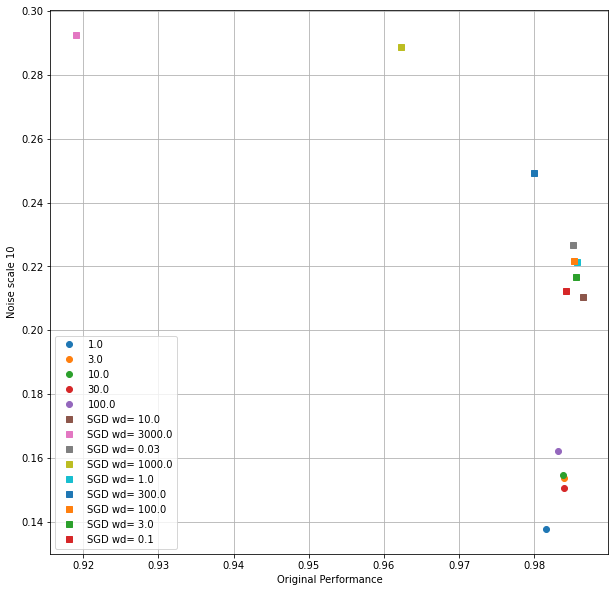

In [22]:

plt.figure(figsize=(10, 10))

# vals = onp.stack([onp.asarray(v) for _, v in hmc_ens_accs.items() if v != []])
# plt.plot(vals[:, 0], vals[:, -1], "bo")

for key, _ in alldirs.items():
    
    marker="o"
    if hmc_ens_accs[key] == []:
        continue
    plt.plot(hmc_ens_accs[key][0], hmc_ens_accs[key][-1], marker, label=key)
for key, _ in sgddirs.items():
    plt.plot(sgd_ind_accs[key][0], sgd_ind_accs[key][-1], "s", label=key)
    
plt.xlabel("Original Performance")
plt.ylabel("Noise scale 10")
plt.grid()
plt.legend()

In [101]:
cmap = matplotlib.cm.get_cmap("tab20")

0
1
2
3
4


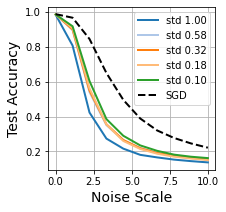

In [102]:
wds = sorted(alldirs)
wds = [wd for wd in wds if hmc_ens_accs[wd] != []]
alphas = onp.linspace(0.3, 1., len(wds))[::-1]

plt.figure(figsize=(3, 3))
for i, wd in enumerate(wds):
    print(i)
    std = onp.sqrt(1 / wd)
    if hmc_ens_accs[wd] == []:
        continue
    plt.plot(noise_scales, hmc_ens_accs[wd], "-", lw=2, 
             label="std {:.2f}".format(std), color=cmap(i))#, alpha=alphas[i], color="g")

plt.plot(noise_scales, sgd_ind_accs["SGD wd= 100.0"], "--k", lw=2, label="SGD", ms=10)

plt.legend()
plt.grid()
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.savefig("gaussian_priors_gaussian_noise.pdf", bbox_inches="tight")

## MNIST-C

In [94]:
from bnn_hmc.utils import data_utils
import tensorflow_datasets as tfds

all_corruptions = tfds.image_classification.mnist_corrupted._CORRUPTIONS

In [95]:
def load_image_dataset(
    split, batch_size, name, repeat=False, shuffle=False,
    shuffle_seed=None
):
    ds, dataset_info = tfds.load(name, split=split, as_supervised=True,
                               with_info=True)
    num_classes = dataset_info.features["label"].num_classes
    num_examples = dataset_info.splits[split].num_examples
    num_channels = dataset_info.features['image'].shape[-1]
    
    def img_to_float32(image, label):
        return tf.image.convert_image_dtype(image, tf.float32), label

    ds = ds.map(img_to_float32).cache()
    ds_stats = data_utils._ALL_IMG_DS_STATS[data_utils.ImgDatasets("mnist")]
    def img_normalize(image, label):
        """Normalize the image to zero mean and unit variance."""
        mean, std = ds_stats
        image -= tf.constant(mean, shape=[1, 1, num_channels], dtype=image.dtype)
        image /= tf.constant(std, shape=[1, 1, num_channels], dtype=image.dtype)
        return image, label

    ds = ds.map(img_normalize)
    if batch_size == -1:
        batch_size = num_examples
    if repeat:
        ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(buffer_size=10 * batch_size, seed=shuffle_seed)
    ds = ds.batch(batch_size)
    return tfds.as_numpy(ds), num_classes, num_examples


def get_image_dataset(name):

    test_set, n_classes, _ = load_image_dataset("test", -1, name)
    test_set = next(iter(test_set))
    
    data_info = {
        "num_classes": n_classes
    }

    return test_set, data_info


def pmap_dataset(ds, n_devices):
    return jax.pmap(lambda x: x)(data_utils.batch_split_axis(ds, n_devices))


def make_mnistc_pmap_fullbatch(corruption, dtype, n_devices=None, truncate_to=None):
    """Make train and test sets sharded over batch dim."""
    name = get_ds_name(corruption).lower()
    n_devices = n_devices or len(jax.local_devices())
    test_set, data_info = get_image_dataset(name)
    loaded = True
    test_set = pmap_dataset(test_set, n_devices)

    test_set = test_set[0].astype(dtype), test_set[1]

    return test_set, task, data_info


def get_ds_name(corruption):
    return "mnist_corrupted/{}".format(corruption)
    

dtype = jnp.float32
test_set, task, data_info = make_mnistc_pmap_fullbatch(all_corruptions[0], dtype)
test_labels = test_set[1]

net_apply, net_init = models.get_model("mlp_classification", data_info)
net_apply = precision_utils.rewrite_high_precision(net_apply)
(_, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)

In [96]:
sgd_ind_accs = {key: {} for key in sgddirs}
hmc_ind_accs = {key: {} for key in alldirs}
hmc_ens_accs = {key: {} for key in alldirs}

for corruption in all_corruptions:
    noisy_test_set, _, _ = make_mnistc_pmap_fullbatch(corruption, dtype)
    
    for key, path in alldirs.items():
        hmc_predictions, predictions = predict_hmc(noisy_test_set, path)
        if hmc_predictions is None:
            continue
        hmc_ens_accs[key][corruption] = metrics.accuracy(hmc_predictions, test_labels)
        hmc_ind_accs[key][corruption] = metrics.accuracy(predictions, test_labels)

    for key, path in sgddirs.items():
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        _, params, net_state, _, _ = (
            checkpoint_utils.parse_sgd_checkpoint_dict(checkpoint_dict))
        predictions = onp.asarray(predict_fn(net_apply, params, net_state, noisy_test_set)[1])
        sgd_ind_accs[key][corruption] = metrics.accuracy(predictions, test_labels)

  0%|          | 0/89 [00:00<?, ?it/s]/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
 33%|███▎      | 29/89 [00:00<00:00, 287.61it/s]

10


 25%|██▍       | 22/89 [00:00<00:00, 212.51it/s]

56


 24%|██▎       | 21/89 [00:00<00:00, 208.70it/s]

81


 24%|██▎       | 21/89 [00:00<00:00, 203.86it/s]

88


100%|██████████| 89/89 [00:00<00:00, 98080.15it/s]


88
0
0


 26%|██▌       | 23/89 [00:00<00:00, 226.08it/s]

10


 24%|██▎       | 21/89 [00:00<00:00, 199.56it/s]

56


 24%|██▎       | 21/89 [00:00<00:00, 200.94it/s]

81


 24%|██▎       | 21/89 [00:00<00:00, 200.24it/s]

88


100%|██████████| 89/89 [00:00<00:00, 110835.23it/s]


88
0
0


 29%|██▉       | 26/89 [00:00<00:00, 247.07it/s]

10


 22%|██▏       | 20/89 [00:00<00:00, 199.27it/s]

56


 21%|██▏       | 19/89 [00:00<00:00, 182.07it/s]

81


 20%|██        | 18/89 [00:00<00:00, 177.63it/s]

88


100%|██████████| 89/89 [00:00<00:00, 88837.00it/s]


88
0
0


 29%|██▉       | 26/89 [00:00<00:00, 248.22it/s]

10


 22%|██▏       | 20/89 [00:00<00:00, 199.41it/s]

56


 21%|██▏       | 19/89 [00:00<00:00, 180.43it/s]

81


 22%|██▏       | 20/89 [00:00<00:00, 199.33it/s]

88


100%|██████████| 89/89 [00:00<00:00, 102863.89it/s]


88
0
0


 29%|██▉       | 26/89 [00:00<00:00, 258.17it/s]

10


 24%|██▎       | 21/89 [00:00<00:00, 208.01it/s]

56


 24%|██▎       | 21/89 [00:00<00:00, 204.38it/s]

81


 22%|██▏       | 20/89 [00:00<00:00, 199.30it/s]

88


100%|██████████| 89/89 [00:00<00:00, 79373.39it/s]


88
0
0


 33%|███▎      | 29/89 [00:00<00:00, 287.41it/s]

10


 24%|██▎       | 21/89 [00:00<00:00, 202.12it/s]

56


 21%|██▏       | 19/89 [00:00<00:00, 189.18it/s]

81


 21%|██▏       | 19/89 [00:00<00:00, 186.28it/s]

88


100%|██████████| 89/89 [00:00<00:00, 87937.12it/s]


88
0
0


 29%|██▉       | 26/89 [00:00<00:00, 259.91it/s]

10


 25%|██▍       | 22/89 [00:00<00:00, 216.68it/s]

56


 22%|██▏       | 20/89 [00:00<00:00, 194.64it/s]

81


 21%|██▏       | 19/89 [00:00<00:00, 189.19it/s]

88


100%|██████████| 89/89 [00:00<00:00, 119072.75it/s]


88
0
0


 28%|██▊       | 25/89 [00:00<00:00, 243.17it/s]

10


 22%|██▏       | 20/89 [00:00<00:00, 192.67it/s]

56


 20%|██        | 18/89 [00:00<00:00, 173.51it/s]

81


 24%|██▎       | 21/89 [00:00<00:00, 202.33it/s]

88


100%|██████████| 89/89 [00:00<00:00, 89091.42it/s]


88
0
0


 26%|██▌       | 23/89 [00:00<00:00, 225.83it/s]

10


 24%|██▎       | 21/89 [00:00<00:00, 204.80it/s]

56


 22%|██▏       | 20/89 [00:00<00:00, 197.97it/s]

81


 21%|██▏       | 19/89 [00:00<00:00, 185.55it/s]

88


100%|██████████| 89/89 [00:00<00:00, 90254.61it/s]


88
0
0


 33%|███▎      | 29/89 [00:00<00:00, 279.42it/s]

10


 25%|██▍       | 22/89 [00:00<00:00, 214.96it/s]

56


 22%|██▏       | 20/89 [00:00<00:00, 196.69it/s]

81


 22%|██▏       | 20/89 [00:00<00:00, 193.43it/s]

88


100%|██████████| 89/89 [00:00<00:00, 111697.50it/s]


88
0
0


 28%|██▊       | 25/89 [00:00<00:00, 241.84it/s]

10


 21%|██▏       | 19/89 [00:00<00:00, 184.70it/s]

56


 22%|██▏       | 20/89 [00:00<00:00, 194.96it/s]

81


 21%|██▏       | 19/89 [00:00<00:00, 185.17it/s]

88


100%|██████████| 89/89 [00:00<00:00, 119262.96it/s]


88
0
0


 33%|███▎      | 29/89 [00:00<00:00, 279.74it/s]

10


 25%|██▍       | 22/89 [00:00<00:00, 209.14it/s]

56


 22%|██▏       | 20/89 [00:00<00:00, 195.64it/s]

81


 22%|██▏       | 20/89 [00:00<00:00, 197.11it/s]

88


100%|██████████| 89/89 [00:00<00:00, 123036.60it/s]


88
0
0


 33%|███▎      | 29/89 [00:00<00:00, 281.29it/s]

10


 25%|██▍       | 22/89 [00:00<00:00, 218.74it/s]

56


 24%|██▎       | 21/89 [00:00<00:00, 202.75it/s]

81


 22%|██▏       | 20/89 [00:00<00:00, 198.94it/s]

88


100%|██████████| 89/89 [00:00<00:00, 70115.15it/s]


88
0
0


 29%|██▉       | 26/89 [00:00<00:00, 259.11it/s]

10


 24%|██▎       | 21/89 [00:00<00:00, 204.16it/s]

56


 21%|██▏       | 19/89 [00:00<00:00, 186.45it/s]

81


 21%|██▏       | 19/89 [00:00<00:00, 183.42it/s]

88


100%|██████████| 89/89 [00:00<00:00, 107268.12it/s]


88
0
0


 28%|██▊       | 25/89 [00:00<00:00, 244.10it/s]

10


 22%|██▏       | 20/89 [00:00<00:00, 192.20it/s]

56


 20%|██        | 18/89 [00:00<00:00, 173.74it/s]

81


 20%|██        | 18/89 [00:00<00:00, 169.78it/s]

88


100%|██████████| 89/89 [00:00<00:00, 97414.68it/s]


88
0
0


 29%|██▉       | 26/89 [00:00<00:00, 249.93it/s]

10


 22%|██▏       | 20/89 [00:00<00:00, 197.76it/s]

56


 21%|██▏       | 19/89 [00:00<00:00, 186.46it/s]

81


 22%|██▏       | 20/89 [00:00<00:00, 198.06it/s]

88


100%|██████████| 89/89 [00:00<00:00, 97060.08it/s]


88
0
0


Text(0.5, 1.0, 'MNIST Robustness')

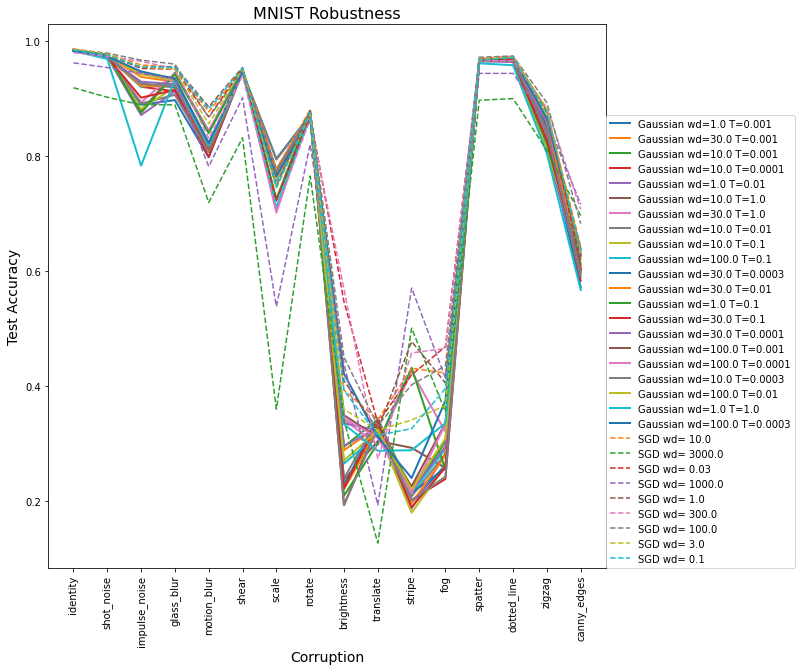

In [32]:
plt.figure(figsize=(10, 10))
xs = onp.arange(len(all_corruptions))
for key, _ in tempdirs.items():
    if hmc_ens_accs[key] == {}:
        continue
    style = "-"
    if hmc_ens_accs[key]["identity"] > 0.95:
        plt.plot(xs, [hmc_ens_accs[key][c] for c in all_corruptions], style, lw=2, label=key, ms=10)

for key, _ in sgddirs.items():
    plt.plot(xs, [sgd_ind_accs[key][c] for c in all_corruptions], "--", label=key)
plt.xticks(xs, all_corruptions, rotation=90)

plt.legend(loc=(1., 0.))
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Corruption", fontsize=14)
plt.title("MNIST Robustness", fontsize=16)

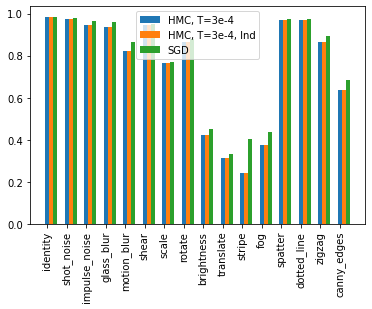

In [44]:
xs = onp.arange(len(all_corruptions))
plt.bar(xs, [hmc_ens_accs["Gaussian wd=100.0 T=0.0003"][c] for c in all_corruptions],
        width=0.2, label="HMC, T=3e-4"
       )
plt.bar(xs+0.2, [hmc_ens_accs["Gaussian wd=100.0 T=0.0003"][c] for c in all_corruptions],
        width=0.2, label="HMC, T=3e-4, Ind"
       )
plt.bar(xs+0.4, [sgd_ind_accs["SGD wd= 100.0"][c] for c in all_corruptions],
        width=0.2, label="SGD"
       )

plt.xticks(xs, all_corruptions, rotation=90)
plt.legend()

In [97]:
cmap = matplotlib.cm.get_cmap("tab20")

0
1
2
3
4


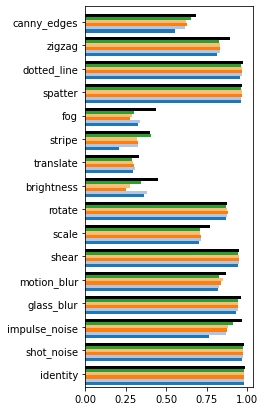

In [98]:
wds = sorted(alldirs)
wds = [wd for wd in wds if hmc_ens_accs[wd] != {}]
num_bars = len(wds) + 1
width = 0.8 / num_bars

plt.figure(figsize=(3, 7))

ys = onp.arange(len(all_corruptions))
for i, wd in enumerate(wds):
    print(i)
    std = onp.sqrt(1 / wd)
    plt.barh(ys + i * width, [hmc_ens_accs[wd][c] for c in all_corruptions],
        height=width, label="std {:.2f}".format(std), color=cmap(i)
    )
    
plt.barh(ys + (num_bars-1) * width, [sgd_ind_accs["SGD wd= 100.0"][c] for c in all_corruptions],
        height=width, label="SGD", color="k" #cmap(len(wds)+1)
    )

plt.ylim(-0.15, 16.05)

plt.yticks(ys+0.4, all_corruptions, rotation=0);
plt.savefig("gaussian_priors_mnistc.pdf", bbox_inches="tight")

In [77]:
all_corruptions

['identity',
 'shot_noise',
 'impulse_noise',
 'glass_blur',
 'motion_blur',
 'shear',
 'scale',
 'rotate',
 'brightness',
 'translate',
 'stripe',
 'fog',
 'spatter',
 'dotted_line',
 'zigzag',
 'canny_edges']

In [ ]:
wds = sorted(alldirs)
alphas = onp.linspace(0.3, 1., len(wds))[::-1]

plt.figure(figsize=(3, 3))
for i, wd in enumerate(wds):
    std = onp.sqrt(1 / wd)
    if hmc_ens_accs[wd] == []:
        continue
    plt.plot(noise_scales, hmc_ens_accs[wd], "-", lw=2, 
             label="std {:.2f}".format(std), color=cmap(i))#, alpha=alphas[i], color="g")

plt.plot(noise_scales, sgd_ind_accs["SGD wd= 100.0"], "--b", lw=2, label="SGD", ms=10, color=cmap(len(wds)+1))

plt.legend()
plt.grid()
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.savefig("gaussian_priors_gaussian_noise.pdf", bbox_inches="tight")

In [45]:
hmc_ens_accs["Gaussian wd=100.0 T=0.0003"]

{'identity': DeviceArray(0.983, dtype=float32),
 'shot_noise': DeviceArray(0.9733, dtype=float32),
 'impulse_noise': DeviceArray(0.9474, dtype=float32),
 'glass_blur': DeviceArray(0.9343, dtype=float32),
 'motion_blur': DeviceArray(0.8226, dtype=float32),
 'shear': DeviceArray(0.9456, dtype=float32),
 'scale': DeviceArray(0.7651, dtype=float32),
 'rotate': DeviceArray(0.866, dtype=float32),
 'brightness': DeviceArray(0.4217, dtype=float32),
 'translate': DeviceArray(0.31129998, dtype=float32),
 'stripe': DeviceArray(0.2402, dtype=float32),
 'fog': DeviceArray(0.3746, dtype=float32),
 'spatter': DeviceArray(0.968, dtype=float32),
 'dotted_line': DeviceArray(0.96989995, dtype=float32),
 'zigzag': DeviceArray(0.86469996, dtype=float32),
 'canny_edges': DeviceArray(0.6383, dtype=float32)}

In [46]:
hmc_ind_accs["Gaussian wd=100.0 T=0.0003"]

{'identity': DeviceArray(0.9833, dtype=float32),
 'shot_noise': DeviceArray(0.97389996, dtype=float32),
 'impulse_noise': DeviceArray(0.94699997, dtype=float32),
 'glass_blur': DeviceArray(0.93509996, dtype=float32),
 'motion_blur': DeviceArray(0.8147, dtype=float32),
 'shear': DeviceArray(0.94479996, dtype=float32),
 'scale': DeviceArray(0.76379997, dtype=float32),
 'rotate': DeviceArray(0.86649996, dtype=float32),
 'brightness': DeviceArray(0.429, dtype=float32),
 'translate': DeviceArray(0.3145, dtype=float32),
 'stripe': DeviceArray(0.2294, dtype=float32),
 'fog': DeviceArray(0.378, dtype=float32),
 'spatter': DeviceArray(0.9686, dtype=float32),
 'dotted_line': DeviceArray(0.96989995, dtype=float32),
 'zigzag': DeviceArray(0.8627, dtype=float32),
 'canny_edges': DeviceArray(0.6347, dtype=float32)}

## Noise along PCA directions

In [111]:
from sklearn.decomposition import PCA

mnist_tr_np = onp.asarray(train_set[0]).reshape(-1, 784)
mnist_te_np = onp.asarray(test_set[0]).reshape(-1, 784)

In [112]:
pca = PCA(n_components=50)
pca.fit(mnist_tr_np)

PCA(n_components=50)

In [113]:
basis = (pca.components_)

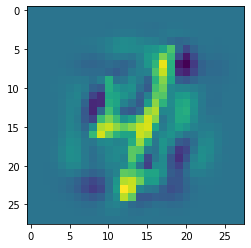

In [115]:
plt.imshow((mnist_tr_np[0] + 2 * onp.random.randn(50) @ basis).reshape(28, 28))

In [116]:
test_set[0].shape

(8, 1250, 28, 28, 1)

In [122]:
sgd_ind_accs = {key: [] for key in sgddirs}
hmc_ind_accs = {key: [] for key in alldirs}
hmc_ens_accs = {key: [] for key in alldirs}
n_test = 10000

noise_scales = onp.linspace(0, 10., 20)
for noise_scale in noise_scales:
    noise = (onp.random.randn(n_test, 50) @ basis).reshape(test_set[0].shape)
    noisy_test_set = test_set[0] + jnp.array(noise) * noise_scale, test_set[1]
    
    for key, path in alldirs.items():
        hmc_predictions, predictions = predict_hmc(noisy_test_set, path)
        if hmc_predictions is None:
            continue
        hmc_ens_accs[key].append(metrics.accuracy(hmc_predictions, test_labels))
        hmc_ind_accs[key].append(metrics.accuracy(predictions, test_labels))

    
    for key, path in sgddirs.items():
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        _, params, net_state, _, _ = (
            checkpoint_utils.parse_sgd_checkpoint_dict(checkpoint_dict))
        predictions = onp.asarray(predict_fn(net_apply, params, net_state, noisy_test_set)[1])
        sgd_ind_accs[key].append(metrics.accuracy(predictions, test_labels))

  0%|          | 0/89 [00:00<?, ?it/s]/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
 24%|██▎       | 21/89 [00:00<00:00, 208.91it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 168.47it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 146.35it/s]

81


 16%|█▌        | 14/89 [00:00<00:00, 130.03it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 212.28it/s]

10


 20%|██        | 18/89 [00:00<00:00, 173.18it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 150.83it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 152.67it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 26%|██▌       | 23/89 [00:00<00:00, 217.42it/s]

10


 20%|██        | 18/89 [00:00<00:00, 174.84it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 159.58it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 159.49it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 26%|██▌       | 23/89 [00:00<00:00, 218.46it/s]

10


 20%|██        | 18/89 [00:00<00:00, 172.64it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 159.18it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 156.62it/s]

88


100%|██████████| 89/89 [00:00<00:00, 86691.37it/s]


88
0
0


 24%|██▎       | 21/89 [00:00<00:00, 205.42it/s]

10


 20%|██        | 18/89 [00:00<00:00, 179.59it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 157.37it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 151.81it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 24%|██▎       | 21/89 [00:00<00:00, 209.37it/s]

10


 17%|█▋        | 15/89 [00:00<00:00, 149.71it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 150.59it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 146.87it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 217.38it/s]

10


 20%|██        | 18/89 [00:00<00:00, 170.10it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 149.29it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 152.95it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 207.37it/s]

10


 20%|██        | 18/89 [00:00<00:00, 170.84it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 148.49it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 141.62it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 21%|██▏       | 19/89 [00:00<00:00, 179.89it/s]

10


 18%|█▊        | 16/89 [00:00<00:00, 156.39it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 149.10it/s]

81


 16%|█▌        | 14/89 [00:00<00:00, 139.98it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 206.32it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 160.35it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 142.49it/s]

81


 16%|█▌        | 14/89 [00:00<00:00, 133.30it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 26%|██▌       | 23/89 [00:00<00:00, 216.29it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 160.82it/s]

56


 16%|█▌        | 14/89 [00:00<00:00, 131.99it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 144.78it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 207.59it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 168.63it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 150.58it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 148.69it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 204.16it/s]

10


 20%|██        | 18/89 [00:00<00:00, 171.64it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 157.52it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 148.26it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 24%|██▎       | 21/89 [00:00<00:00, 195.59it/s]

10


 20%|██        | 18/89 [00:00<00:00, 171.45it/s]

56


 17%|█▋        | 15/89 [00:00<00:00, 148.47it/s]

81


 15%|█▍        | 13/89 [00:00<00:00, 128.73it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 24%|██▎       | 21/89 [00:00<00:00, 202.50it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 159.35it/s]

56


 16%|█▌        | 14/89 [00:00<00:00, 139.24it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 153.10it/s]

88


100%|██████████| 89/89 [00:00<00:00, 98650.38it/s]


88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 212.54it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 166.23it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 153.39it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 151.82it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 213.71it/s]

10


 19%|█▉        | 17/89 [00:00<00:00, 167.54it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 153.76it/s]

81


 17%|█▋        | 15/89 [00:00<00:00, 148.20it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 211.53it/s]

10


 20%|██        | 18/89 [00:00<00:00, 173.93it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 158.38it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 155.44it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 22%|██▏       | 20/89 [00:00<00:00, 190.24it/s]

10


 20%|██        | 18/89 [00:00<00:00, 173.02it/s]

56


 16%|█▌        | 14/89 [00:00<00:00, 137.91it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 153.62it/s]

88


  0%|          | 0/89 [00:00<?, ?it/s]

88
0
0


 25%|██▍       | 22/89 [00:00<00:00, 216.77it/s]

10


 20%|██        | 18/89 [00:00<00:00, 174.47it/s]

56


 18%|█▊        | 16/89 [00:00<00:00, 152.44it/s]

81


 18%|█▊        | 16/89 [00:00<00:00, 155.54it/s]

88


100%|██████████| 89/89 [00:00<00:00, 97848.77it/s]


88
0
0


Text(0.5, 0, 'Noise Scale')

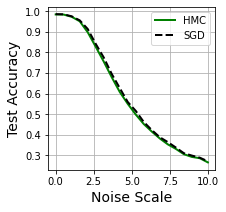

In [125]:
wds = sorted(alldirs)
wds = [wd for wd in wds if hmc_ens_accs[wd] != []]
alphas = onp.linspace(0.3, 1., len(wds))[::-1]

plt.figure(figsize=(3, 3))

wd = 10.
std = onp.sqrt(1 / wd)
plt.plot(noise_scales, hmc_ens_accs[wd], "-", lw=2, 
         label="HMC".format(std), color="g")#, alpha=alphas[i], color="g")

plt.plot(noise_scales, sgd_ind_accs["SGD wd= 100.0"], "--k", lw=2, label="SGD", ms=10)

plt.legend()
plt.grid()
plt.ylabel("Test Accuracy", fontsize=14)
plt.xlabel("Noise Scale", fontsize=14)
plt.savefig("gaussian_prior_pca_gaussian_noise.pdf", bbox_inches="tight")

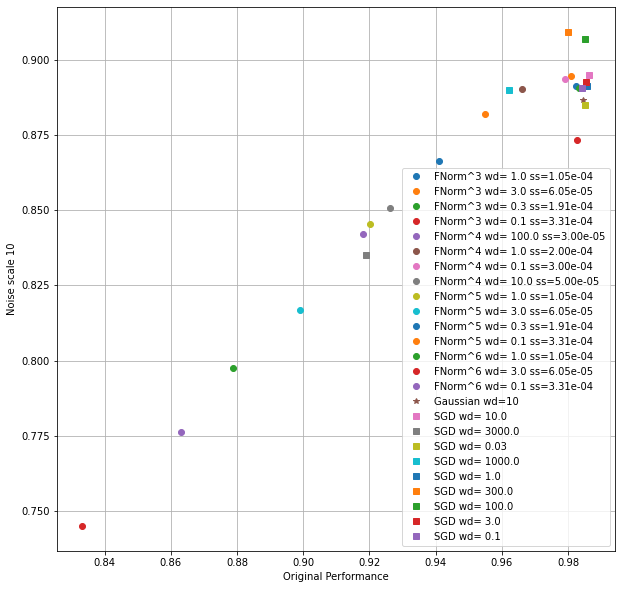

In [27]:

plt.figure(figsize=(10, 10))

# vals = onp.stack([onp.asarray(v) for _, v in hmc_ens_accs.items() if v != []])
# plt.plot(vals[:, 0], vals[:, -1], "bo")

for key, _ in alldirs.items():
    if hmc_ens_accs[key] == []:
        continue
    if key == "Gaussian wd=10":
        marker = "*"
    else:
        marker="o"
    plt.plot(hmc_ens_accs[key][0], hmc_ens_accs[key][-1], marker, label=key)
for key, _ in sgddirs.items():
    plt.plot(sgd_ind_accs[key][0], sgd_ind_accs[key][-1], "s", label=key)
    
plt.xlabel("Original Performance")
plt.ylabel("Noise scale 10")
plt.grid()
plt.legend()